# Feature selection with Random Forest

# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from constants import RF_FEATURE_SELECTION_PARAMS, NUM_FEATURES, CAT_FEATURES

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

from dask import delayed, compute
from dask.diagnostics import ProgressBar

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

import optuna
from optuna.samplers import TPESampler

# Data Loading

In [2]:
X_list = []
y_list = []

for i in range(10):
    X = pd.read_parquet(f"../../../../../data/interim/copper/X_train_bal/X_{i}.parquet")
    y = pd.read_parquet(f"../../../../../data/interim/copper/y_train_bal/y_{i}.parquet")

    X_list.append(X)
    y_list.append(y)

X_train = pd.read_parquet("../../../../../data/interim/copper/X_train.parquet")
y_train = pd.read_parquet("../../../../../data/interim/copper/y_train_cat.parquet")

# Tunnig Random Forest


## Setting Up Pipeline Steps

In [3]:
over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")

numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
    ])

categorical_transformer = Pipeline(steps=[
    ('binary_encoder', BinaryEncoder())
])

preprocessor = ColumnTransformer(
        transformers=[
            ('num_pca', numeric_transformer, NUM_FEATURES),
            ('cat', categorical_transformer, CAT_FEATURES)
        ]
    )

rkf= RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

## Optimization

In [29]:
def objective(trial):

    params = dict()
    params['n_estimators'] = trial.suggest_int('n_estimators', 1, 100)
    params['max_depth'] = trial.suggest_int('max_depth', 2, 7)
    params['max_features'] = trial.suggest_int('max_features', 1, 27)
    params['min_samples_split'] = trial.suggest_int('min_samples_split', 2, 50)
    params['min_samples_leaf'] = trial.suggest_int('min_samples_leaf', 1, 30)
    params['random_state'] = trial.suggest_int('random_state', 1, 100) 
    params['class_weight'] = 'balanced'
    params['n_jobs'] = -1

    steps_list =[('preprocessor', preprocessor),
        ('over', over),
        ('under', under),]


    model = RandomForestClassifier(**params)

    steps_list.append(('classifier', model))

    pipe = ImbPipeline(steps_list)

    scores = cross_val_score(pipe, X_train, y_train, cv=rkf, scoring="roc_auc")

    return np.mean(scores), np.std(scores)

study = optuna.create_study(directions=['maximize', 'minimize'], sampler=TPESampler())
study.optimize(objective, n_trials=1000)

[I 2024-10-23 21:26:00,584] A new study created in memory with name: no-name-c733cfe1-d0df-44aa-8a15-29291bebf404


[I 2024-10-23 21:26:01,865] Trial 0 finished with values: [0.6534849114064231, 0.11849700138185011] and parameters: {'n_estimators': 66, 'max_depth': 2, 'max_features': 24, 'min_samples_split': 48, 'min_samples_leaf': 17, 'random_state': 88}.
[I 2024-10-23 21:26:02,741] Trial 1 finished with values: [0.6588385935769656, 0.10671553999472833] and parameters: {'n_estimators': 20, 'max_depth': 6, 'max_features': 24, 'min_samples_split': 49, 'min_samples_leaf': 3, 'random_state': 22}.
[I 2024-10-23 21:26:03,436] Trial 2 finished with values: [0.6561288759689923, 0.11222148242962737] and parameters: {'n_estimators': 12, 'max_depth': 7, 'max_features': 24, 'min_samples_split': 37, 'min_samples_leaf': 27, 'random_state': 36}.
[I 2024-10-23 21:26:04,880] Trial 3 finished with values: [0.6709544573643411, 0.11163005127077992] and parameters: {'n_estimators': 85, 'max_depth': 3, 'max_features': 17, 'min_samples_split': 42, 'min_samples_leaf': 28, 'random_state': 89}.
[I 2024-10-23 21:26:05,906] T

In [30]:
optuna.visualization.plot_pareto_front(study, target_names=["mean ROC-AUC", "std ROC-AUC"])

In [ ]:
#Selected trial
study_df = study.trials_dataframe()
study_df[study_df['number'] == 345]

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_min_samples_leaf,params_min_samples_split,params_n_estimators,params_random_state,state
345,345,0.716234,0.048805,2024-10-23 21:31:34.781092,2024-10-23 21:31:35.513954,0 days 00:00:00.732862,5,1,4,50,6,17,COMPLETE


In [35]:
#study_df.to_parquet("../../../../data/processed/copper/optuna_results_random_forest_raw_train.parquet")  # Save the results to a parquet file

# Feature selection with Boruta

In [4]:
def importance_extimation(X, y, i):
    """ Calculate the importance of the features using the Boruta algorithm given a seed i """
    model = RandomForestClassifier(RF_FEATURE_SELECTION_PARAMS)

    feat_selector = BorutaPy(model, n_estimators="auto", random_state=i)

    feat_selector.fit(X, y)

    return feat_selector.ranking_

@delayed
def importance_experiment(X_list, y_list, i):
    """ Run the importance estimation experiment for a given seed i and sampled datasets X and y.
    Returns the ranking of the features for each i, X and y."""
    rankings_list = [importance_extimation(X.values, y.values, i) for X, y in zip(X_list, y_list)]

    return rankings_list

In [5]:
# Create a list of delayed tasks
tasks = [importance_experiment(X_list, y_list, i) for i in range(5)]

# Use Dask to compute the results in parallel
with ProgressBar():
    experiments = compute(*tasks)

[########################################] | 100% Completed | 573.83 s


In [6]:
# each element of the list is a list of rankings 
# for each pair X and y from X_list and y_list, 
# for a given seed i used in Boruta.

experiments[0]

[array([ 1,  9,  2,  1,  1,  1,  9,  3,  3,  1, 14,  1,  1,  1,  1,  1,  1,
         1, 11,  3,  3,  6, 15,  1, 16,  3,  7,  1,  8,  1, 11, 13],
       dtype=int32),
 array([ 1,  7,  3,  1,  1,  1, 17, 15, 10,  3, 20,  1,  1,  3,  2,  1,  1,
         3, 16,  7, 14, 12, 19,  1, 18,  3, 13,  1,  7,  1, 11,  9],
       dtype=int32),
 array([ 1,  4,  2,  1,  1,  1,  9,  3,  6,  2, 15,  1,  1,  2,  1,  1,  1,
         1,  7,  1,  1,  4, 14,  1, 13,  1,  8,  1, 11,  1, 12, 10],
       dtype=int32),
 array([ 1,  5,  4,  1,  1,  1, 14,  3,  6,  7, 18,  1,  1,  2,  1,  1,  1,
         1, 10,  7, 12, 12, 19,  1, 20,  9, 16,  1, 11,  1, 14, 16],
       dtype=int32),
 array([ 1,  3,  1,  1,  1,  1, 11,  2,  8,  1, 15,  1,  1,  5,  1,  1,  1,
         1,  9,  1,  2,  5, 15,  1, 12,  5,  9,  1,  7,  1, 14, 12],
       dtype=int32),
 array([ 1, 10,  3,  1,  1,  1,  9,  8,  6,  3, 16,  1,  1,  2,  1,  1,  1,
         1, 12,  5, 11,  6, 17,  1, 18,  1, 14,  1,  3,  1, 12, 15],
       dtype=int32),
 arr

In [7]:
exp_dfs = []

for exp in experiments:
    #Here reset_index create a index for each experiment
    exp_dfs.append(pd.DataFrame(exp, columns=X.columns).reset_index())

# Create experiments dataframe
exp_df = pd.concat(exp_dfs)
exp_df.reset_index(drop=True, inplace=True)

In [8]:
exp_df.head(20)

,index,GOLD_DENSITY,SILVER_DENSITY,PRECIOUS_ORE_DENSITY,COPPER_GRADE,INITIAL_COST,ORE_TONNAGE,PRECIOUS_GRAMS,COPPER_TONNAGE,ECONOMIC_AMOUNT,...,LOG_10_SILVER_GRAMS,LOG_10_INITIAL_COST_PER_AMOUNT,GEOLOGIC_ORE_BODY_TYPE_0,GEOLOGIC_ORE_BODY_TYPE_1,GEOLOGIC_ORE_BODY_TYPE_2,GLOBAL_REGION_0,GLOBAL_REGION_1,GLOBAL_REGION_2,MINE_TYPE_0,MINE_TYPE_1
0,0,1,9,2,1,1,1,9,3,3,...,15,1,16,3,7,1,8,1,11,13
1,1,1,7,3,1,1,1,17,15,10,...,19,1,18,3,13,1,7,1,11,9
2,2,1,4,2,1,1,1,9,3,6,...,14,1,13,1,8,1,11,1,12,10
3,3,1,5,4,1,1,1,14,3,6,...,19,1,20,9,16,1,11,1,14,16
4,4,1,3,1,1,1,1,11,2,8,...,15,1,12,5,9,1,7,1,14,12
5,5,1,10,3,1,1,1,9,8,6,...,17,1,18,1,14,1,3,1,12,15
6,6,1,11,3,1,1,1,13,4,6,...,20,1,17,9,9,1,13,1,18,15
7,7,1,11,4,1,1,1,17,7,9,...,16,1,19,6,13,1,10,1,14,15
8,8,1,13,7,1,1,1,14,6,9,...,20,1,19,4,11,1,8,1,17,15
9,9,1,10,3,1,1,1,7,2,2,...,14,1,16,3,13,1,9,1,13,11


In [10]:
exp_median_df = exp_df.groupby("index").median()

plot_df = (
    exp_median_df.T
    .reset_index()
    .rename(columns={"index": "feature"})
    .melt(id_vars="feature", var_name="experiment", value_name="rank")
)

order = plot_df.groupby("feature")["rank"].mean().sort_values().index

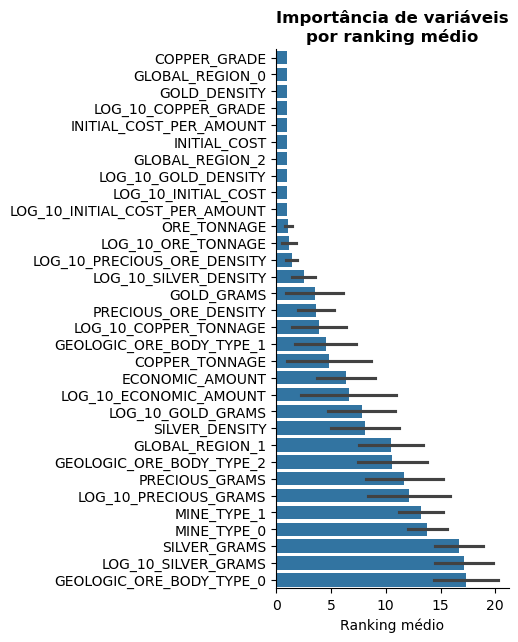

In [14]:
plt.figure(figsize=(3, 7))
ax = sns.barplot(plot_df, y = "feature", x = "rank", orient="h", order=order, errorbar="sd")
ax.set_title("Importância de variáveis\npor ranking médio", weight="bold")
ax.set_xlabel("Ranking médio")
ax.set_ylabel("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)